# Explore the effect of overlap size in slicing embeddings for scenarios having different network-feature correlation

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict, Counter
import warnings
import functools
import pickle
import gc
import datetime

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import pandas as pd
import networkx as nx
import dask
import distributed

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback
from tqdm import tqdm_notebook as tqdm

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching
from nw2vec import generative
import settings

Using TensorFlow backend.


In [2]:
client = distributed.Client('localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 25 Cores: 25 Memory: 150.00 GB


In [3]:
N_ALPHAS = 10
N_MODEL_SAMPLES = 20
N_CLUSTERINGS = 2
N_NODES = 750
N_CLUSTERS = 75
OVERWRITE_RESULTS = False
COLORS_PATH = os.path.join(settings.BEHAVIOUR_PATH, 'colors')
RESULTS_PATH = (COLORS_PATH
                + '/S2_S3-ov_noov-n_nodes={n_nodes}-n_clusters={n_clusters}'
                + '-n_alphas={n_alphas}-n_models={n_models}-n_clusterings={n_clusterings}'
                + '-{data_name}.pkl')

## Creating the scenarios

In [4]:
α_range = np.linspace(start=0, stop=1, num=N_ALPHAS, endpoint=True)
π_gap_range = np.linspace(start=.075, stop=.12, num=N_CLUSTERINGS, endpoint=True)

def scenario_from_aid_cid(aid, cid, n_nodes=N_NODES, n_clusters=N_CLUSTERS):
    α = α_range[aid]
    ρ = np.ones(n_clusters) / n_clusters
    π_gap = π_gap_range[cid]
    π = ((.13 + π_gap) * np.diag(np.ones(n_clusters))
         + (.13 - π_gap) * (np.ones((n_clusters, n_clusters)) - np.diag(np.ones(n_clusters))))
    Y, A, labels = generative.colors(n_nodes, ρ, π, α)
    features = labels + np.random.normal(scale=.1, size=labels.shape)
    return Y, scipy.sparse.csr_matrix(A), labels, features

## Build the VAEs

The rest of the notebook generates VAE models for the different scenarios and different overlaps. This section defines the model-generating function.

In [5]:
# Define the last VAE Parameters
n_ξ_samples = 5  # Number of embeddings sampled at the embedding layer.

def get_loss_weights(n_nodes, dims, q_overlap):
    dim_data, _, dim_ξ_adj, dim_ξ_v = dims
    return {
        # embedding-gaussian divergence scales with number of embedding dimensions,
        # but we also don't want it to overpower the other losses, hence the 1e-2
        'q_mulogS_flat': 1000 * 1e-3 * 1.0 / (dim_ξ_adj - q_overlap + dim_ξ_v),  
        # Adj loss scales with the number of nodes
        'p_adj': 1000 * 1.0 / (n_nodes * np.log(2)),
        # Feature loss scales with the average number of sampled words
        'p_v': 1000 * 1.0 / np.log(dim_data),
    }

def make_vae(n_nodes, dims, q_overlap, p_ξ_slices):
    """Build a VAE with features of dimension `dims`,
    and an overlap size of `q_overlap` between adj and feature embeddings,
    and p_ξ_slices distributing embedding outputs to adj/feature tasks.
    
    Returns
    -------
    q_model : nw2vec.ae.Model
        The encoder model.
    q_codecs : list of strings
        The list of codec names (corresponding to subclasses of nw2vec.codecs.Codec)
        used to interpret the output of `q_model`. Currently this list has always a single item.
    vae : nw2vec.ae.Model
        The full VAE, which includes `q_model`.
    vae_codecs : list of strings
        The list of codec names used to interpret the output of `vae`. The output of `vae` is made of
        the output of `q_model` (so that the first codec name her is always the single codec in `q_codecs`),
        the adjacency reconstruction, and the feature reconstruction.
    
    In the original model, the adj and feature outputs of `vae` would be parameters to distributions
    from which you sample to create a prediction. For the adjacency, they would be numbers between 0 and 1
    (parameters to a Bernoulli distribution for each value in the matrix). The same goes for binary features.
    For non-binary features, we use a Gaussian distribution for feature prediction, so the output for features
    would be the μ values and values of the diagonal of log(Σ) (just like the parametrisation of the embeddings).
    But! The last operation on these layers would be a sigmoid, and the loss we compute downstream
    is a cross-entropy loss, and the combination of these two is not numerically stable (it easily vanishes to 0).
    
    So instead, we push the sigmoid operation into the loss computation (implemented in the codec object,
    where sigmoid and cross-entropy are combined into a numerically stable operation), such that what
    the `vae` outputs for the adj and feature predictions is the values that should go into a sigmoid.
    (This is why some codecs are named 'Sigmoid*'.)
    
    Long story short: if you want to plot predictions, you must:
    1) put the `vae` output values for adj and features into a sigmoid
    2) sample from those values according to what the parameters represent
       (i.e. Bernoulli or parametrised Gaussian).
    
    The plot_predictions() function above does that for you.
    
    """
    
    dim_data, dim_l1, dim_ξ_adj, dim_ξ_v = dims
    
    # Build the encoder model
    q_model, q_codecs = ae.build_q(
        dims,
        # Size of the overlap between the separated adj and feature layers
        # which are combined (with overlap) to construct the embedding
        overlap=q_overlap,
        # Function used to generate fullbatches,
        # used behind the scenes by Model.predict_fullbatch() and Model.fit_fullbatches()
        fullbatcher=batching.fullbatches,
        # Function used to generate minibatches,
        # used behind the scenes by Model.predict_minibatches() and Model.fit_minibatches()
        minibatcher=batching.pq_batches)
    
    # Build a function which, given an input (which would be the embeddings, i.e. the output of the
    # encoder model), will produce the output of the decoder.
    p_builder = ae.build_p_builder(
        dims,
        # The input features are not binary, but between 0 and 1 summing to 1,
        # so we model them as Multinomial variables.
        # The output of the model for the features is therefore passed to the nw2vec.codecs.SoftmaxMultinomial
        # codec, which knows how to compute the loss values.
        feature_codec='SoftmaxMultinomial',
        # Slices used to separate what part of the embeddings is used for adjacency prediction from what part
        # is used for feature prediction. After sampling of embedding values (using the parameters output by
        # the encoder), the first item in this list defines the input to adjacency decoding, and the second
        # item defines the input to feature decoding. In this case they overlap with `overlap` dimensions.
        embedding_slices=p_ξ_slices,
        # Whether or not to use an intermediate layer in decoding.
        with_l1=True,
        # If `with_l1=True`, this defines whether the adjacency flow and the feature flow share the same weights
        # for their intermediate decoding layer.
        share_l1=False)
    
    # Build the actual VAE. This takes the encoder, adds a sampling layer, puts that into the decoder,
    # and compiles the resulting model.
    vae, vae_codecs = ae.build_vae(
        # Encoder and decoder parameters used to create the VAE
        (q_model, q_codecs), p_builder,
        # Number of samples to generate at the embedding layer.
        n_ξ_samples,
        # Weights used in computing the total final loss of the model. The three values are applied to
        # 1) the divergence between embeddings and a standard centred Gaussian
        # 2) the ajd reconstruction loss
        # 3) the feature reconstruction loss
        loss_weights=get_loss_weights(n_nodes, dims, q_overlap)
    )
    
    return q_model, q_codecs, vae, vae_codecs

A few notes about the above:
* Decoding seems to be much better with an intermediate dense layer (i.e. `with_l1=True`) before the final dense layer for feature reconstruction and the bilinear layer for adjacency reconstruction
* The weights for this layer should NOT be shared between adj and feature tracks (i.e. `shared_l1=False`), since this would re-create a dependency between the separated parts of the embeddings.

Now show what the model looks like (the parameters given to `make_vae` have no effect on this drawing). Ignore all the *\_mask and *\_adj inputs (wich are placeholders) to get a real view of the architecture.

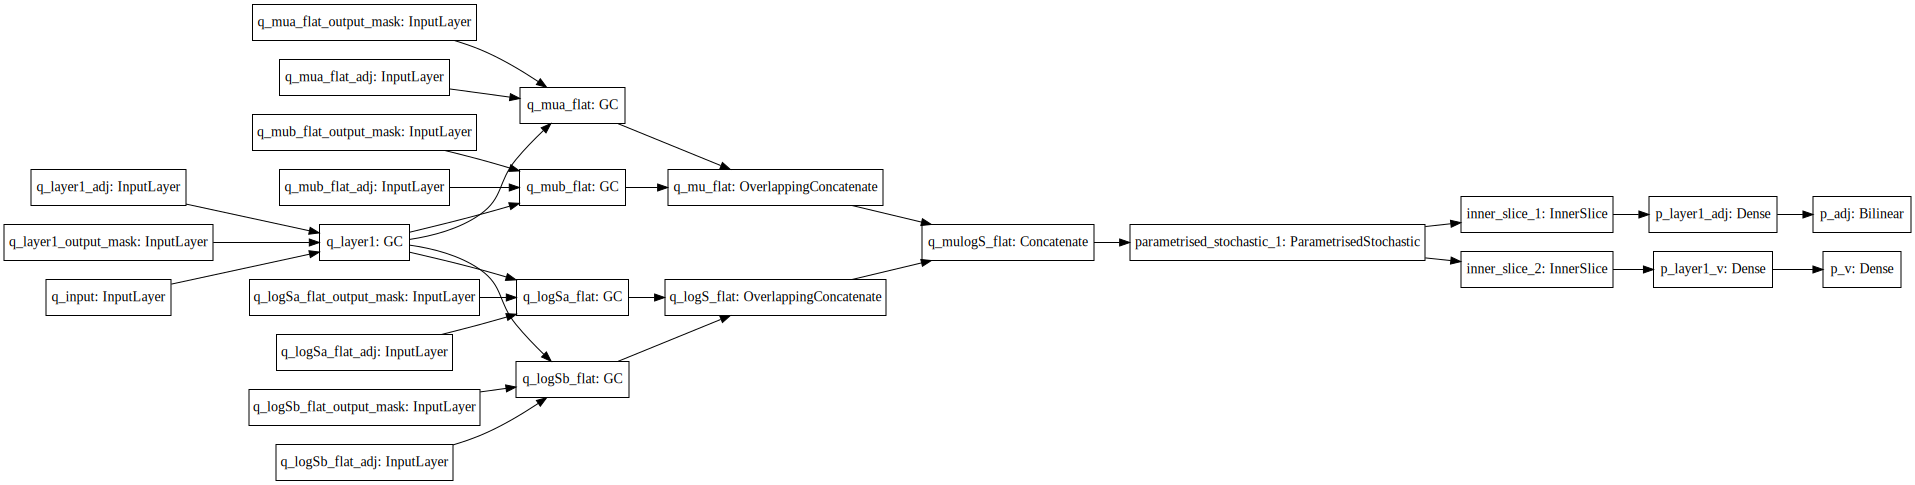

In [6]:
display(SVG(model_to_dot(make_vae(1, (20, 10, 5, 5), 1, None)[2], rankdir='LR').create(prog='dot', format='svg')))

## Train

This section generates VAE models with different overlap values for each of the STBM scenarios, and trains them on the distributed Dask cluster. It recovers the history of the losses during training, and the weights of the trained models.

We start by defining the training parameters, and some helpers for the loops further down.

In [44]:
# Maximum number of epochs to train for
n_epochs = 1000

# `target_func` is given to the training function (in fact it's given as a parameter to the fullbatcher,
# through an argument to the training function) and generates the values against which training loss is computed
# for each batch. The complexity of this comes from the fact that for minibatches, the targets change at each
# minibatch (which is why we need a function to create the targets for each minibatch). In the fullbatch case
# the targets are always the same, but the way it's coded is unchanged so we're left with a bit of useless
# complexity here.
# The target values also depend on the STBM scenario used, so here we make a function which
# creates a `target_func` given the STBM node labels.
def make_target_func(labels):
    
    def target_func(batch_adj, required_nodes, final_nodes):
        """Create training targets given the batch's adjacency matrix, the subset of nodes it used as input,
        and the set of nodes for which output values are computed.
        
        In the minibatch setting, `required_nodes` is usually the 2-hop neighbourhood of `final_nodes`.
        In the fullbatch setting all this is constant and equal to the values of the full dataset.
        
        """
        
        # Keras requires a target value for each output of the model trained,
        # so we have one entry per output/loss in the model. Each entry must also have
        # a shape which is compatible with the corresponding output, which is why we have
        # the `utils.expand_dims_tile()` calls: the target value is the same for each of the
        # values generated from the `n_ξ_samples` embeddings.
        return [
            # Keras feeds this to the embedding-gaussian divergence loss function,
            # but we ignore this input in the actual loss function.
            np.zeros(1), # ignored
            # Target value for adjacency reconstruction
            utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]),
                                                          0, n_ξ_samples),
                                   0, 1),
            # Target value for feature reconstruction
            utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
        ]
    
    return target_func

def train(model, A, labels, features, with_progress=True):
    """Train `model` using adjacency matrix `A` and `labels` as input.
    
    `with_progress` controls whether or not to show a TQDM progress bar.
    
    Note that the fullbatcher takes care of normalising and centring the input labels,
    so `labels` can be the verbatim values from the STBM scenario.
    
    """
    
    # Show a progressbar if asked to.
    callbacks = []
    if with_progress:
        callbacks.append(TQDMCallback(show_inner=False, leave_outer=False))
    
    # Ignore warnings here: TensorFlow always complains that we convert a sparse matrix to a dense matrix,
    # which might use memory. I know, it's an open issue on GitHub, but it's not a problem for now.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return model.fit_fullbatches(
            # kwargs sent to the fullbatch generator. See `nw2vec.batching.fullbatches()` to see
            # what happens to these.
            batcher_kws={'adj': A, 'features': features, 'target_func': make_target_func(labels)},
            # Self-explanatory.
            epochs=n_epochs, verbose=0, callbacks=callbacks
        )

def make_train_vae(dims, q_overlap, p_ξ_slices, skey, with_progress=True):
    """Build a VAE, train it, and return the training history and trained weights.
    
    Returns
    -------
    history : dict of (string, ndarray)
        Dict associating loss name to the history of that loss value during model training
        Includes total loss and components that make up the total.
    
    """
    
    scenario = scenario_from_aid_cid(*skey)
    _, A, labels, features = scenario
    # This function runs in Dask workers, i.e. in another process on another machine. We need to make sure
    # there is a different session for each worker (which is where tensor values are stored),
    # and setting the default TF session does just that.
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config).as_default():
        # Create the model given our parameters.
        q_model, _, vae, _ = make_vae(A.shape[0], dims, q_overlap, p_ξ_slices)
        # Actually train the model.
        history = train(vae, A, labels, features, with_progress=with_progress)
        # Massage the output history and return both history and model weights. Both these values
        # are picklable, so travel without problem across processes and across the network
        # (i.e. across Dask workers).
        # Note that keras models can't be sent easily across the network, as pickling them
        # requires many hacks. Instead we just transport the weights, and recreate any model
        # we want to inspect on the receiver end, i.e. in this notebook process.
        history = dict((title, np.array(values)) for title, values in history.history.items())
        return history

### List utilities

A couple helper functions for managing the list of trained models and training histories we generate below.

In [8]:
def select(selector, items, unique_item=True, unique_output=True):
    """Select one or several values in `items` that match `selector`.
    
    (This is just a way of avoiding nested dicts.)
    
    `items` is a list of tuples, where each tuple contains parameters and
    a value resulting from those parameters. For instance, items is a list of
    values like `(scenario_name, overlap_size, sampling_id, training_history)`.
    In this case we want to be able to get the `training_history` corresponding
    to a combination of `(scenario_name, overalp_size, sampling_id)`, which
    will be the selector. We do that by calling `select(selector, items)`.
    
    Parameters
    ----------
    selector : tuple
        Tuple according to which we select.
    items : list of tuples
        List of items in which we select. This function returns the item(s) for which
        `item[:len(selector)] == selector`, truncated to what's left after removing the
        `selector` part of the item.
    unique_item : bool, optional
        If False:
        * If `selector` selects a unique item, return a list containing only that item.
        * If `selector` selects several items, return the list of those items.
        If True:
        * If `selector` selects a unique item, return that item (not in a list).
        * Raise an error if `selector` does not select a unique item.
        Defaults to True.
    unique_output : bool, optional
        If False, return `item[len(selector):]` (or a list thereof), which is a sequence;
        in particular if `selector` leaves more than one value to its right in the `item` tuple,
        return all those values. If True, return the last value in the item tuple (and not a sequence),
        and raise an error if `selector` doesn't exhaust all but one value in the item tuple.
        Defaults to True.
    
    Returns
    -------
    With default options, `select((1, 2), [(1, 1, 'a'), (1, 2, 'b')]) == 'b'`, which is what you want.
    `unique_item` and `unique_output` let you return things like `('b',)`, `[`b`]`, and `[('b',)]`.
    
    """
    
    lim = len(selector)
    filtered = list(filter(lambda item: item[:lim] == selector, items))
    filtered = [item[lim:] for item in filtered]
    if unique_output:
        for item in filtered:
            assert len(item) == 1
        filtered = [item[0] for item in filtered]
    if unique_item:
        assert len(filtered) == 1
        return filtered[0]
    else:
        return filtered

### Actual training

We're now in a position to generate a range of models (different overlaps for each scenario) and train them on the Dask cluster.

In [9]:
# Where our results will go.
submitted = {}

max_dim_ξ = 20
assert max_dim_ξ % 2 == 0
dim_l1 = max(max_dim_ξ, int(np.round(np.exp(np.mean(np.log([max_dim_ξ, N_CLUSTERS]))))))

MODEL_OVERLAP = 'overlap'
MODEL_NOOVERLAP = 'no-overlap'

In [11]:
#import time
#
#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)
#K.set_session(sess)
#
#start_time = time.time()
#
#dim_ξ_adj = max_dim_ξ // 2
#dim_ξ_v = max_dim_ξ // 2
#q_overlap = 0
#p_ξ_slices = [slice(0, dim_ξ_adj), slice(dim_ξ_adj - q_overlap, dim_ξ_adj - q_overlap + dim_ξ_v)]
#dims = (N_CLUSTERS, dim_l1, dim_ξ_adj, dim_ξ_v)
#
#history = make_train_vae(dims, q_overlap, p_ξ_slices, (5, 1))
#train_time = time.time()
#
#print('train time =', train_time - start_time)

In [12]:
def submit_training(**kws):
    dims = (N_CLUSTERS, kws['dim_l1'], kws['dim_ξ_adj'], kws['dim_ξ_v'])
    
    scenario_key = (kws['aid'], kws['cid'])
    model_key = (kws['model_type'], kws['dim_ξ'], kws['q_overlap'], kws['sampling_id'])
    
    history = client.submit(
        make_train_vae, dims, kws['q_overlap'], kws['p_ξ_slices'], scenario_key,
        # Don't show progress bars for these tasks, there are hundreds of them.
        with_progress=False,
        # They key uniquely identifies a task in Dask, so it's important we include the sampling id here,
        # or Dask would just assume the different samples are the same task.
        key=('make_train_vae', id(make_train_vae),  # function definition
             scenario_key,  # scenario definition
             model_key)  # model definition
    )
    return (scenario_key, model_key, history)

def cluster_saturated(client, tasks):
    return len([task for task in tasks if task.status == 'pending']) >= len(client.ncores())

# Sample several points for each (scenario, overlap).
for sampling_id in tqdm(range(N_MODEL_SAMPLES)):
    # Loop over scenarios
    for cid in [1]:#tqdm(range(N_CLUSTERINGS)):
        for aid in tqdm(range(N_ALPHAS)):
            # Loop over all overlap values: 0 to complete overlap
            for dim_ξ in tqdm(range(max_dim_ξ, max_dim_ξ // 2 - 1, -2)):
                for model_type in tqdm([MODEL_OVERLAP, MODEL_NOOVERLAP]):
                    if model_type == MODEL_OVERLAP:
                        dim_ξ_adj = max_dim_ξ // 2
                        dim_ξ_v = max_dim_ξ // 2
                        q_overlap = max_dim_ξ - dim_ξ
                        assert q_overlap <= min(dim_ξ_adj, dim_ξ_v)
                        p_ξ_slices = [slice(0, dim_ξ_adj),
                                      slice(dim_ξ_adj - q_overlap, dim_ξ_adj - q_overlap + dim_ξ_v)]
                    else:
                        assert model_type == MODEL_NOOVERLAP
                        dim_ξ_adj = dim_ξ // 2
                        dim_ξ_v = dim_ξ // 2
                        q_overlap = 0
                        p_ξ_slices = [slice(0, dim_ξ_adj),
                                      slice(dim_ξ_adj, dim_ξ_adj + dim_ξ_v)]
                    
                    skey, mkey, history = submit_training(**{
                        'aid': aid, 'cid': cid,
                        'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
                        'model_type': model_type, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
                        'p_ξ_slices': p_ξ_slices,
                        'sampling_id': sampling_id
                    })
                    submitted[(skey, mkey)] = history

### Gather successful tasks and save to disk

In [13]:
#gathered = {}

In [48]:
statuses = Counter(map(lambda t: t.status, submitted.values()))

while statuses['pending'] + statuses['lost'] + statuses['finished'] > 0:
    for (skey, mkey), history in submitted.items():#tqdm(submitted.items()):
        if (skey, mkey) not in gathered and history.status == 'finished':
            gathered[(skey, mkey)] = history.result()

    for (skey, mkey) in gathered.keys():
        submitted.pop((skey, mkey), None)

    gc.collect();

    if OVERWRITE_RESULTS:
        with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                      n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                      data_name='histories'),
                  'wb') as f:
            pickle.dump(gathered, f)
    
    print("Gathered finished tasks ({})".format(datetime.datetime.utcnow()))
    time.sleep(300)
    statuses = Counter(map(lambda t: t.status, submitted.values()))

Gathered finished tasks (2018-11-05 08:44:25.387952)


In [49]:
print('gathered:', len(gathered))
print('rest:', Counter(map(lambda t: t.status, submitted.values())))

gathered: 2400
rest: Counter()


### Relaunch errored tasks

In [46]:
for (skey, mkey), history in tqdm(submitted.items()):
    if history.status == 'cancelled':
        aid, cid = skey
        model_type, dim_ξ, q_overlap, sampling_id = mkey
        if model_type == MODEL_OVERLAP:
            dim_ξ_adj = max_dim_ξ // 2
            dim_ξ_v = max_dim_ξ // 2
            q_overlap = max_dim_ξ - dim_ξ
            assert q_overlap <= min(dim_ξ_adj, dim_ξ_v)
            p_ξ_slices = [slice(0, dim_ξ_adj),
                          slice(dim_ξ_adj - q_overlap, dim_ξ_adj - q_overlap + dim_ξ_v)]
        else:
            assert model_type == MODEL_NOOVERLAP
            dim_ξ_adj = dim_ξ // 2
            dim_ξ_v = dim_ξ // 2
            q_overlap = 0
            p_ξ_slices = [slice(0, dim_ξ_adj),
                          slice(dim_ξ_adj, dim_ξ_adj + dim_ξ_v)]

        new_skey, new_mkey, history = submit_training(**{
            'aid': aid, 'cid': cid,
            'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
            'model_type': model_type, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
            'p_ξ_slices': p_ξ_slices,
            'sampling_id': sampling_id
        })
        assert skey == new_skey
        assert mkey == new_mkey
        submitted[(skey, mkey)] = history

## Training loss ~ overlap

Finally we plot the results of the trainings. This is all standard Pandas+Seaborn code.

In [50]:
# Massage the history values into a DataFrame
results = defaultdict(list)
min_ids = np.zeros(len(gathered), dtype=int)

for i, (((aid, cid), (model_type, dim_ξ, q_overlap, sampling_id)), history) in enumerate(gathered.items()):
    for title, values in history.items():
        if title != 'loss':
            continue
        results['alpha_id'].append(aid)
        results['clustering_id'].append(cid)
        results['loss'].append(title)
        results['weighted best'].append(values.min())
        min_ids[i] = values.argmin()
        results['model_type'].append(model_type)
        results['dim_ξ'].append(dim_ξ)
        results['Δ_dim_ξ'].append(max_dim_ξ - dim_ξ)
        results['q_overlap'].append(q_overlap)
        results['sampling_id'].append(sampling_id)

for i, (((aid, cid), (model_type, dim_ξ, q_overlap, sampling_id)), history) in enumerate(gathered.items()):
    if model_type == MODEL_OVERLAP:
        dims = (N_CLUSTERS, dim_l1, max_dim_ξ // 2, max_dim_ξ // 2)
    else:
        assert model_type == MODEL_NOOVERLAP
        dims = (N_CLUSTERS, dim_l1, dim_ξ // 2, dim_ξ // 2)
    loss_weights = get_loss_weights(N_NODES, dims, q_overlap)
    for title, values in history.items():
        if title == 'loss':
            continue
        results['alpha_id'].append(aid)
        results['clustering_id'].append(cid)
        results['loss'].append(title)
        results['weighted best'].append(values[min_ids[i]] * loss_weights[title[:-5]])
        results['model_type'].append(model_type)
        results['dim_ξ'].append(dim_ξ)
        results['Δ_dim_ξ'].append(max_dim_ξ - dim_ξ)
        results['q_overlap'].append(q_overlap)
        results['sampling_id'].append(sampling_id)

results = pd.DataFrame(results)

In [54]:
if OVERWRITE_RESULTS:
    results.to_pickle(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                          n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                          data_name='df'))

In [55]:
#with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
#                              n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
#                              data_name='df'), 'rb') as f:
#    results = pickle.load(f)

In [56]:
results_orig = results

In [57]:
results_long = results.pivot_table(columns='loss',
                                   index=['alpha_id', 'clustering_id', 'model_type',
                                          'dim_ξ', 'Δ_dim_ξ', 'sampling_id'],
                                   values='weighted best')
results_long['adj_v_loss'] = results_long['p_adj_loss'] + results_long['p_v_loss']
results = results_long.stack().reset_index().rename(columns={0: 'weighted best'})

In [58]:
results_rel_Δ_dim_ξ = results.pivot_table(columns='Δ_dim_ξ',
                                          index=['alpha_id', 'clustering_id', 'model_type',
                                                 'sampling_id', 'loss'],
                                          values='weighted best')
results_rel_Δ_dim_ξ = results_rel_Δ_dim_ξ.apply(
    lambda x: (x - results_rel_Δ_dim_ξ[0]) / results_rel_Δ_dim_ξ[0])
results_rel_Δ_dim_ξ = results_rel_Δ_dim_ξ.stack().reset_index().rename(columns={0: 'weighted best'})

Absolute

/scratch/cayolacabra/anaconda3/envs/base36-cbpgpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


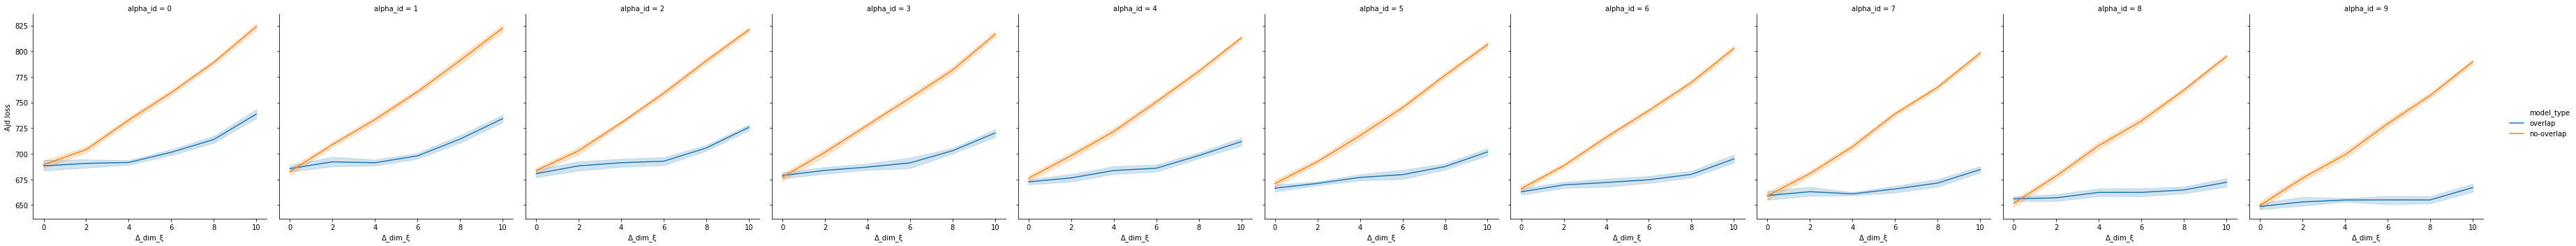

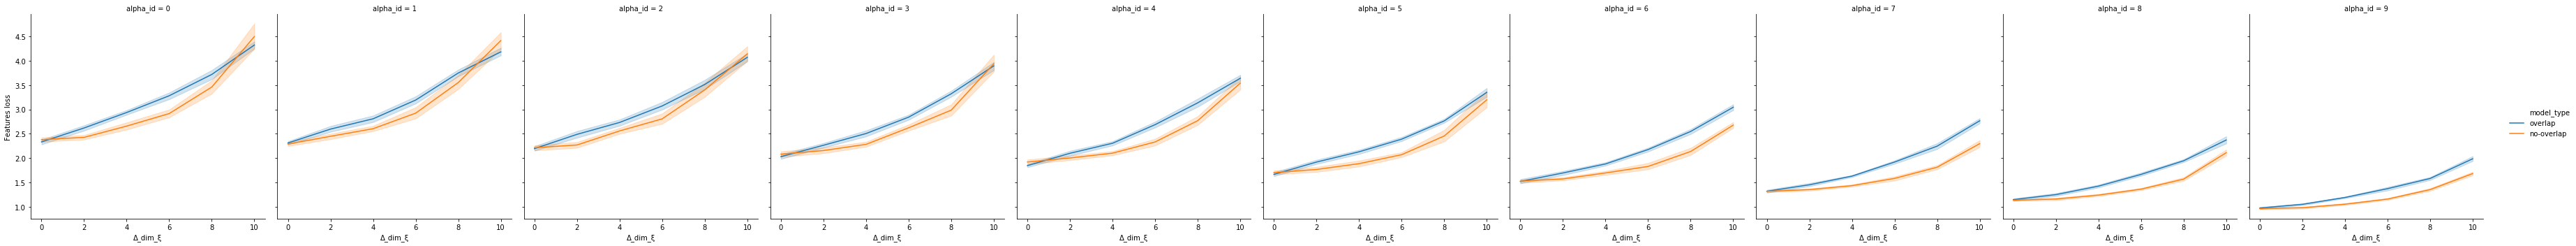

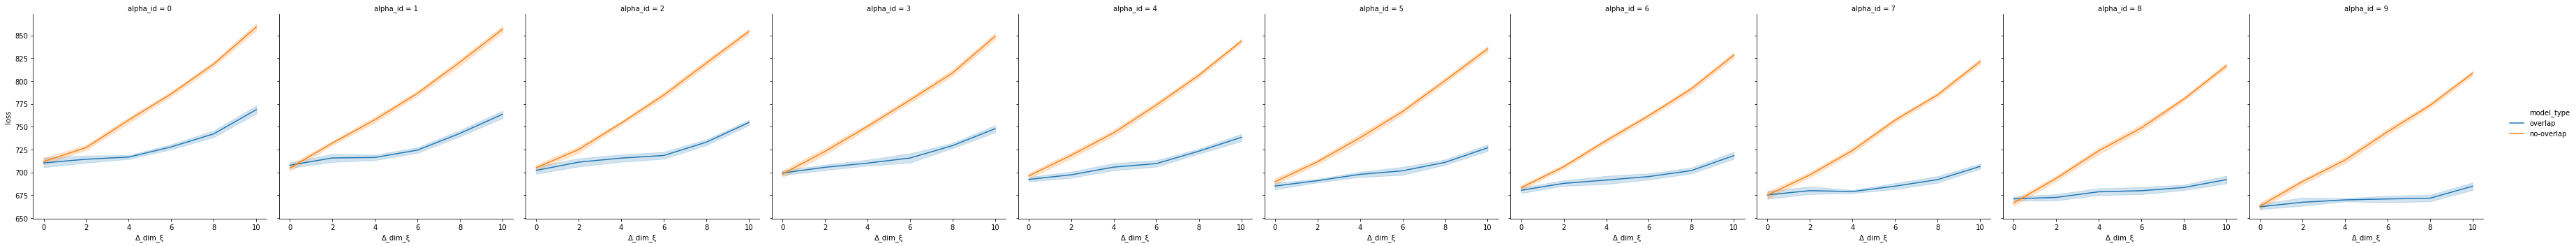

In [59]:
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_adj_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Ajd loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_v_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

Relative

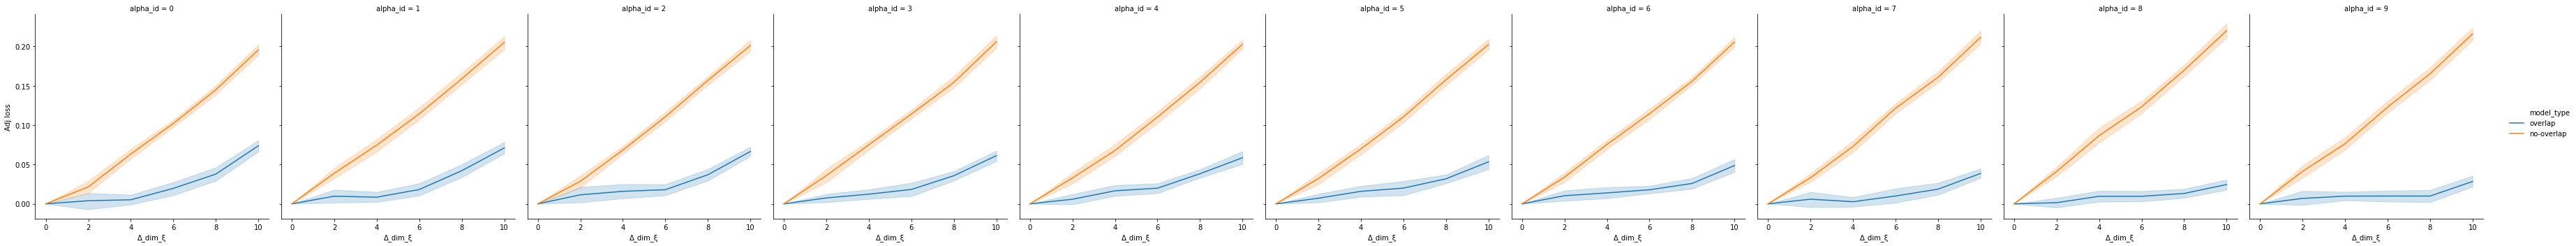

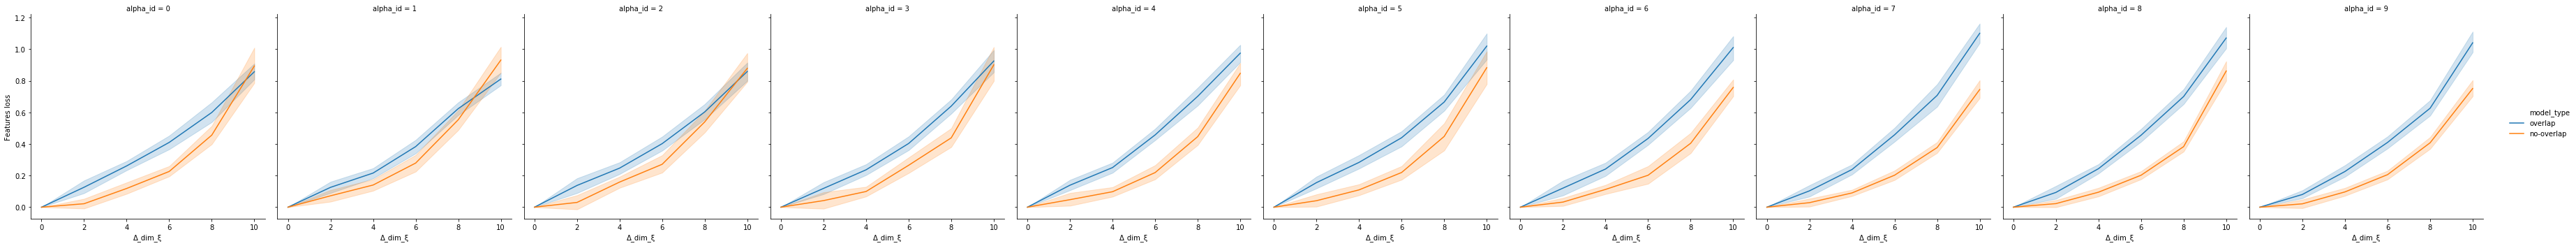

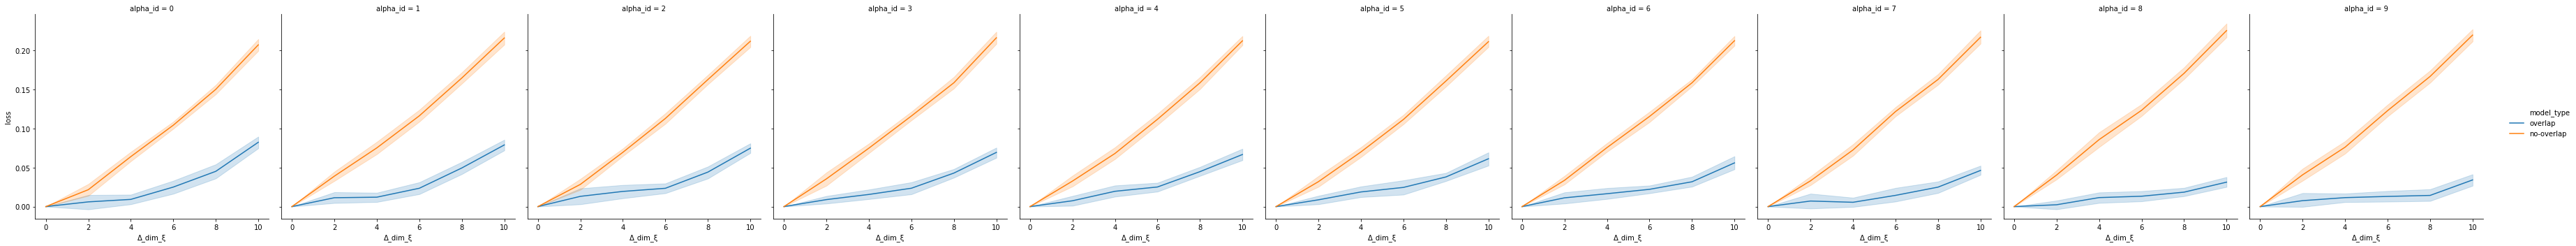

In [60]:
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_adj_loss')
                                                  & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_v_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

Absolute

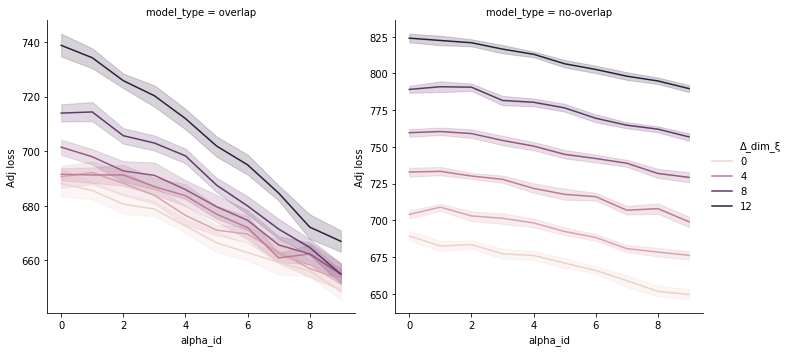

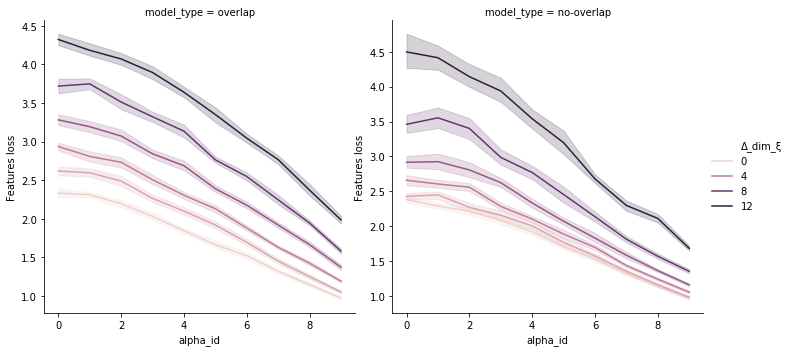

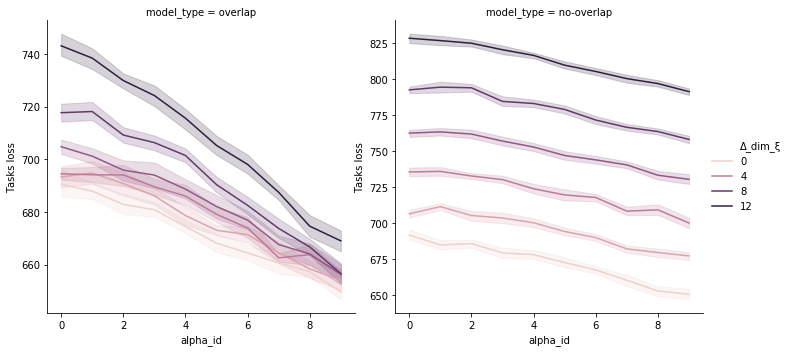

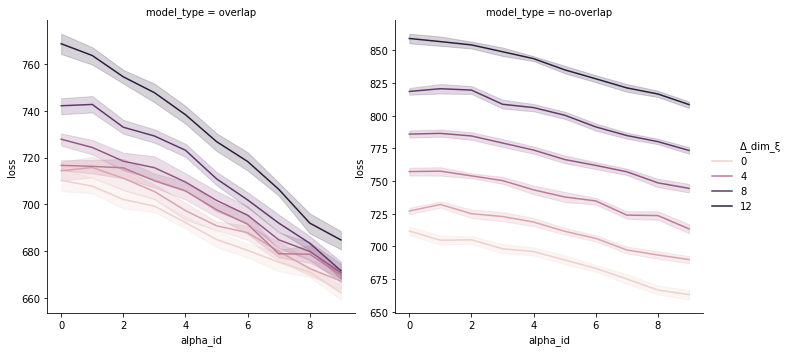

In [61]:
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_adj_loss')
                                     & (results.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_v_loss')
                                     & (results.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'adj_v_loss')
                                     & (results.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Tasks loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'loss')
                                     & (results.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='loss')

Relative

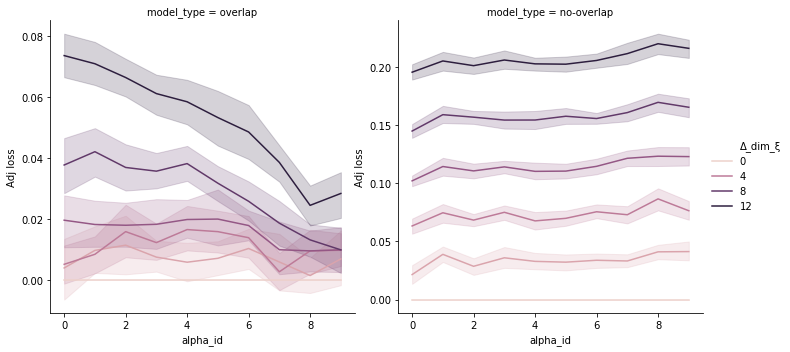

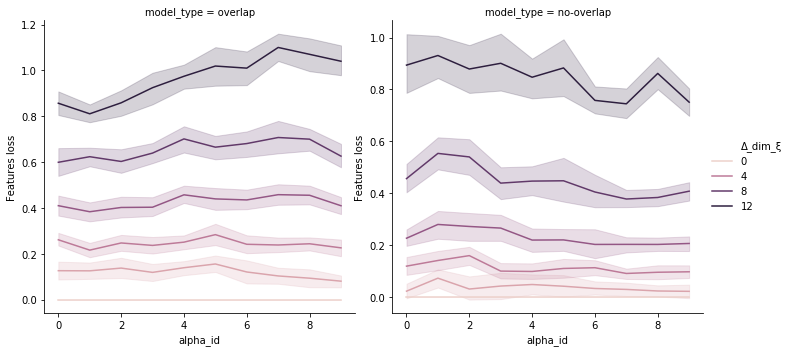

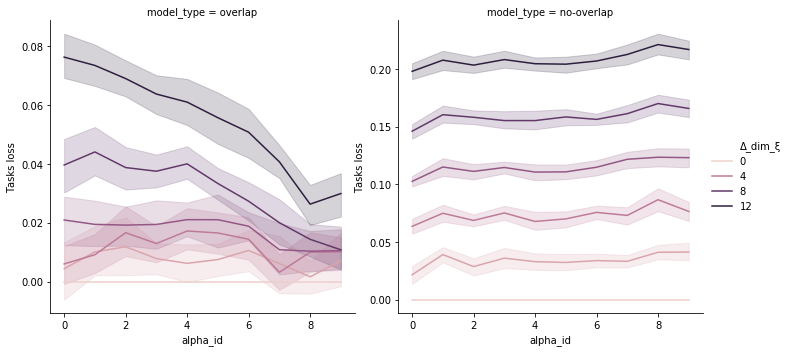

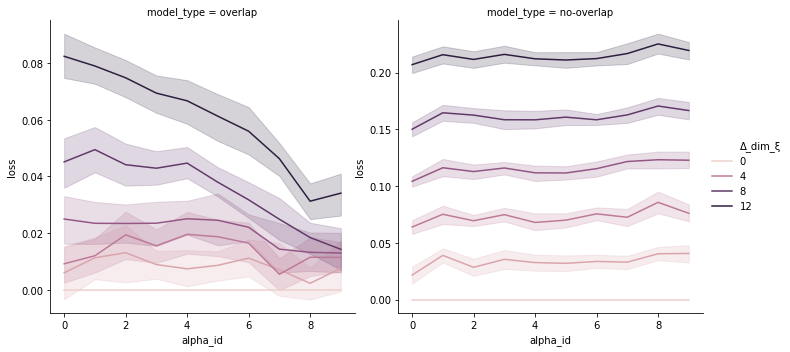

In [62]:
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_adj_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_v_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'adj_v_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='Tasks loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line', facet_kws={'sharey': False})
facet_grid.set(ylabel='loss')

## Example results of a VAE

In [ ]:
history_ov10 = gathered[((0, 1), ('overlap', 10, 10, 1))]
dims_ov10 = (N_CLUSTERS, dim_l1, 10, 10)
loss_weights_ov10 = get_loss_weights(N_NODES, dims_ov10, 10)

history_ov0 = gathered[((0, 1), ('overlap', 20, 0, 1))]
dims_ov0 = (N_CLUSTERS, dim_l1, 10, 10)
loss_weights_ov0 = get_loss_weights(N_NODES, dims_ov0, 0)

history_noov = gathered[((0, 1), ('no-overlap', 10, 0, 1))]
dims_noov = (N_CLUSTERS, dim_l1, 5, 5)
loss_weights_noov = get_loss_weights(N_NODES, dims_noov, 0)

In [ ]:
fig, axes = plt.subplots(1, len(history_ov), figsize=(len(history_ov) * 5, 4))
for i, ((title_ov10, values_ov10), (title_ov0, values_ov0), (title_noov, values_noov)) in \
        enumerate(zip(history_ov10.items(), history_ov0.items(), history_noov.items())):
    assert title_ov10 == title_ov0 == title_noov
    axes[i].plot(np.array(values_ov10) * loss_weights_ov10.get(title_ov10[:-5], 1), label='ov10')
    axes[i].plot(np.array(values_ov0) * loss_weights_ov0.get(title_ov10[:-5], 1), label='ov0')
    axes[i].plot(np.array(values_noov) * loss_weights_noov.get(title_ov10[:-5], 1), label='noov')
    axes[i].set_title(title_ov10)
    axes[i].legend()
#axes[0].set_ylim(970, 1200)
#axes[2].set_ylim(900, 1000)
#axes[3].set_ylim(0, 125)
fig.tight_layout()

In [ ]:
history_ov0['loss'][-1], history_ov10['loss'][-i]

In [ ]:
for history, loss_weights in (history_ov0, loss_weights_ov0), (history_ov10, loss_weights_ov10):
    print(history['loss'][-1], np.sum([history[name][-1] * loss_weights[name[:-5]] for name in ['p_adj_loss', 'p_v_loss', 'q_mulogS_flat_loss']]))

In [ ]:
history = make_train_vae((N_CLUSTERS, dim_l1, 10, 10), 10, [slice(0, 10), slice(0, 10)], (0, 1))
dims = (N_CLUSTERS, dim_l1, 10, 10)
loss_weights = get_loss_weights(N_NODES, dims, 10)

In [ ]:
fig, axes = plt.subplots(1, len(history), figsize=(len(history) * 5, 4))
for i, (title, values) in enumerate(history.items()):
    axes[i].plot(np.array(values) * loss_weights.get(title[:-5], 1))
    axes[i].set_title(title)
fig.tight_layout()